In [1]:
import bayesnewton
import jax
import objax
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from sklearn.preprocessing import StandardScaler
from convertbng.util import convert_bng, convert_lonlat
import time
from sklearn.model_selection import train_test_split
import datetime
import math   

import cv2
import sys, os
sys.path.append('../Utils')
import model_utils as mutils
import kernels_definitions as kerns
%load_ext autoreload
%autoreload 2

/Users/SeanNassimiha/miniforge3/envs/mscjax_dev/lib/python3.8/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
#DATA VARIABLES
SYSTEMS_NUM = 15
TIMESTEPS_NUM = 500 
TRAIN_FRAC = 0.9
GRID_PIXELS = 20

#OPTIMISATION VARIABLES
LR_ADAM = 0.05
LR_NEWTON = 0.5
ITERS = 3

#GP Variables
VAR_Y = 0.5
VAR_F = 0.5
LEN_TIME = 20  # step size = 1 (hour)
LEN_SPACE = 1.5

#Want to use a sparse approximation
SPARSE = True
#Should we optimise the inducing points
OPT_Z = False  # will be set to False if SPARSE=SPARSE

#use a mean field approximation?
MEAN_FIELD = False
MINI_BATCH_SIZE = None #none if you don't want them

TEST_STATIONS = 10

In [3]:
data =  pd.read_csv('../../Data/pv_power_df_5day_capacity_scaled.csv', index_col='datetime').drop(columns=['2657', '2828']) #DROPPING FAULTY SYSTEMS
uk_pv = pd.read_csv('../../Data/system_metadata_location_rounded.csv')
uk_pv['ss_id_string'] = uk_pv['ss_id'].astype('str')
#data_multiple.plot(legend=False)
lats = dict(uk_pv.set_index('ss_id')['latitude_noisy'])
longs = dict(uk_pv.set_index('ss_id')['longitude_noisy'])
data_multiple = data.iloc[:, :SYSTEMS_NUM][:TIMESTEPS_NUM].reset_index()
stacked = mutils.stack_dataframe(data_multiple, lats, longs)
capacities = uk_pv[uk_pv.ss_id_string.isin(data_multiple.columns)].set_index('ss_id_string')['kwp'].values * 1000



In [4]:
X = np.array(stacked[['epoch', 'longitude', 'latitude']])
Y = np.array(stacked[['PV']])

# convert to easting and northings
british_national_grid_coords = convert_bng(X[:, 1], X[:, 2])
X = np.vstack([X[:, 0],
              np.array(british_national_grid_coords[0]),
              np.array(british_national_grid_coords[1])]).T

#Create a space-time grid from X and Y
t, R, Y = bayesnewton.utils.create_spatiotemporal_grid(X, Y)


/Users/SeanNassimiha/miniforge3/envs/mscjax_dev/lib/python3.8/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


Text(0.5, 1.0, 'Grid of initial inducing points')

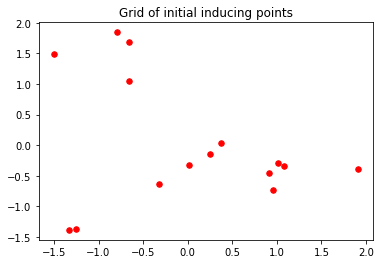

In [5]:
#train test split for 3 dimensional data
t_train, t_test, R_train, R_test, Y_train, Y_test = mutils.train_split_3d(t, R, Y, train_frac = TRAIN_FRAC, split_by_day = False)

#get the mask of the test points
test_mask = np.in1d(t.squeeze(), t_test.squeeze())

#Scale the data
scaled_values = mutils.scale_2d_train_test_data(R, Y, R_train, R_test, Y_train, Y_test )
R_scaler, R_scaled, R_train_scaled, R_test_scaled, _, _, _, _ = scaled_values

#here get a list of scaled coordinates (frozen because at some point in time)
R_scaled_frozen = R_scaled[0]

# #Create a grid to perform prediction/interpolation on
r1, r2, Rplot = mutils.create_grid_from_coords(R = R_scaled_frozen, t = t, R_scaler = R_scaler, N_pixels = GRID_PIXELS)

z = R_scaled[2, ...] 

    
plt.scatter(*zip(*z), marker='o', s=30, color='red')
plt.title('Grid of initial inducing points')


In [6]:
kern = kerns.get_SpatioTemporal_combined(variance=VAR_F,
                                           lengthscale_time=LEN_TIME,
                                           lengthscale_space=[LEN_SPACE, LEN_SPACE],
                                           z=z,
                                           sparse=SPARSE,
                                           opt_z=OPT_Z,
                                           matern_order = '32',
                                           conditional='Full')

In [7]:
# R_total_train = np.concatenate((R_train_scaled, Rplot[:450]), axis=1)
# Y_rplot_nans = np.zeros((Y_train.shape[0], Rplot.shape[1], 1 ))
# Y_rplot_nans[:,:,:] = np.nan
# Y_total_train = np.concatenate((Y_train, Y_rplot_nans), axis=1)



if MEAN_FIELD:
    lik = bayesnewton.likelihoods.Beta(scale = 30, fix_scale=False, link='probit')
    model = bayesnewton.models.MarkovVariationalMeanFieldGP(kernel=kern, likelihood=lik, X=t_train, R=R_train_scaled, Y=Y_train, parallel = True)
else:    
    lik = bayesnewton.likelihoods.Beta(scale = 30, fix_scale=False, link='probit')
    model = bayesnewton.models.MarkovVariationalGP(kernel = kern, likelihood = lik, X=t_train, Y=Y_train, R=R_train_scaled)
    
opt_hypers = objax.optimizer.Adam(model.vars())
energy = objax.GradValues(model.energy, model.vars())

@objax.Function.with_vars(model.vars() + opt_hypers.vars())
def train_op(batch_ind = None):
    model.inference(lr=LR_NEWTON, batch_ind = batch_ind)  # perform inference and update variational params
    dE, E = energy()  # compute energy and its gradients w.r.t. hypers
    opt_hypers(LR_ADAM, dE)
    return E

# train_op = objax.Jit(train_op)


/Users/SeanNassimiha/miniforge3/envs/mscjax_dev/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5373: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


In [8]:
if MINI_BATCH_SIZE == None:
    number_of_minibatches = 1
    mini_batches_indices = [None] * number_of_minibatches
else:
    number_of_minibatches = int(len(t_train) / MINI_BATCH_SIZE)
    idx_set = np.arange(len(t_train))
    np.random.shuffle(idx_set)
    mini_batches_indices = np.array_split(idx_set, number_of_minibatches)

In [9]:
t0 = time.time()
for i in range(1, ITERS + 1):
    for mini_batch in range(number_of_minibatches):
        if number_of_minibatches > 1:
            print(f'Doing minibatch {mini_batch}')
        loss = train_op(mini_batches_indices[mini_batch])
    print('iter %2d, energy: %1.4f' % (i, loss[0]))
t1 = time.time()
print('optimisation time: %2.2f secs' % (t1-t0))
avg_time_taken = (t1-t0)/ITERS


iter  1, energy: -9842.4549
iter  2, energy: -15889.3520
iter  3, energy: -19560.1855
optimisation time: 20.09 secs


In [10]:
# calculate posterior predictive distribution via filtering and smoothing at train & test locations:
t0 = time.time()
print('calculating the posterior predictive distribution ...')
posterior_mean, posterior_var = model.predict_y(X=t, R=Rplot)
t1 = time.time()
print('prediction time: %2.2f secs' % (t1-t0))

t2 = time.time()
print('calculating the negative log predictive density ...')
nlpd = model.negative_log_predictive_density(X=t_test, R=R_test_scaled, Y=Y_test)
t3 = time.time()
print('nlpd calculation time: %2.2f secs' % (t3-t2))
print('nlpd: %2.3f' % nlpd)


calculating the posterior predictive distribution ...
prediction time: 6.64 secs
calculating the negative log predictive density ...
nlpd calculation time: 4.94 secs
nlpd: -3.459


In [11]:
z_opt = model.kernel.z.value
# mu = Y_scaler.inverse_transform(posterior_mean.flatten()[:, np.newaxis]).reshape(-1, GRID_PIXELS, GRID_PIXELS)
mu = posterior_mean.reshape(TIMESTEPS_NUM, GRID_PIXELS, GRID_PIXELS)
Y = Y[:,:,0]

#get lat-lon coordinates
grid_coord = R_scaler.inverse_transform(np.array(np.c_[r1,r2]))
longitude_grid, latitude_grid =  convert_lonlat(grid_coord[:, 0], grid_coord[:, 1])
longitude_sys_train, latitude_sys_train = convert_lonlat(R_train[:,:,0][0], R_train[:,:,1][0])
longitude_z, latitude_z = convert_lonlat(R_scaler.inverse_transform(z_opt)[:,0], R_scaler.inverse_transform(z_opt)[:,1])


plotting ...


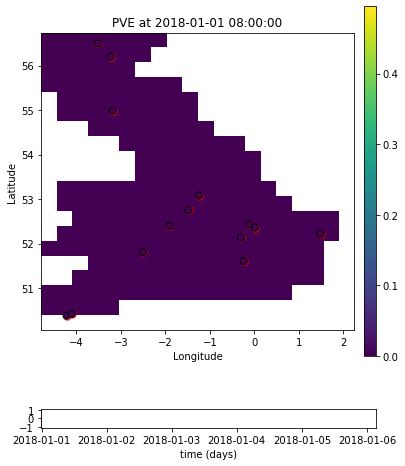

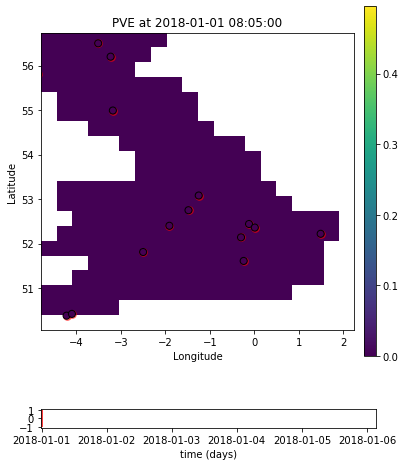

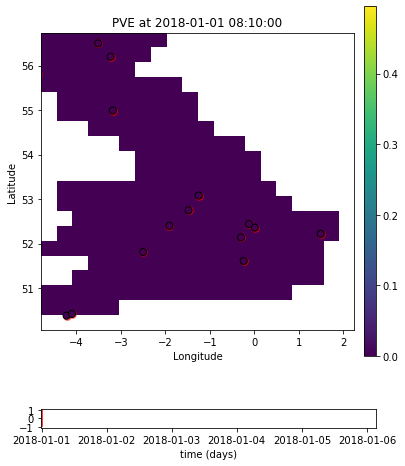

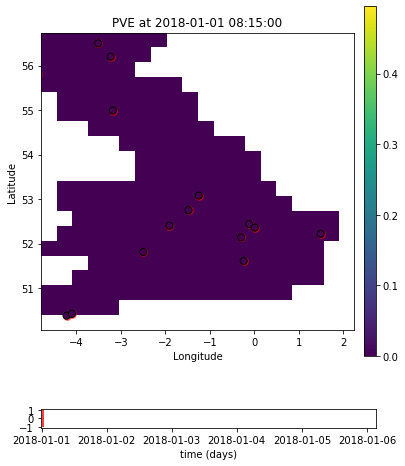

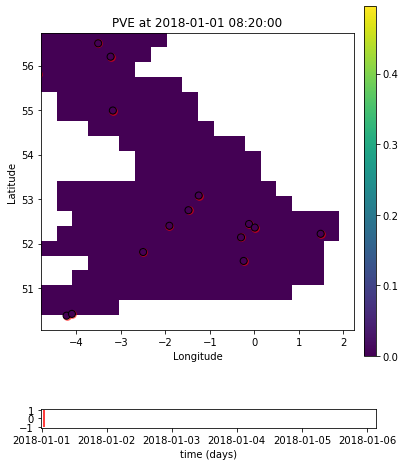

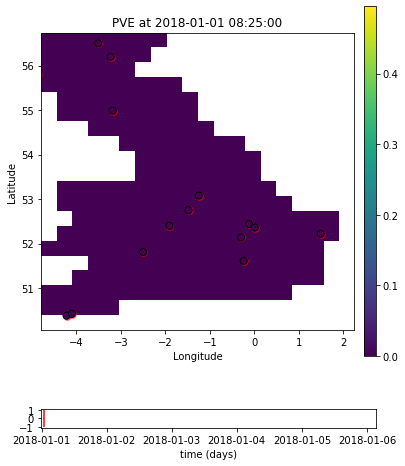

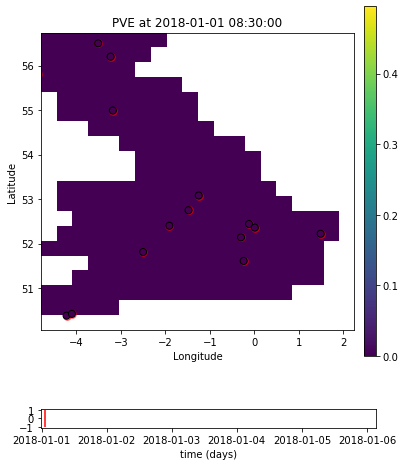

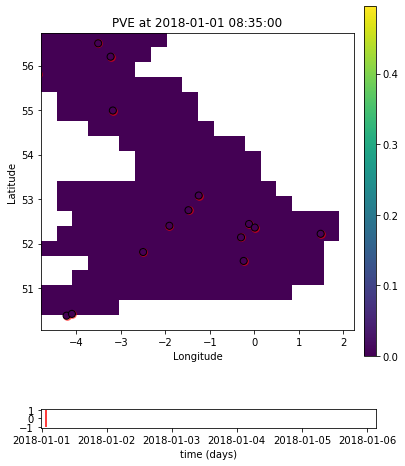

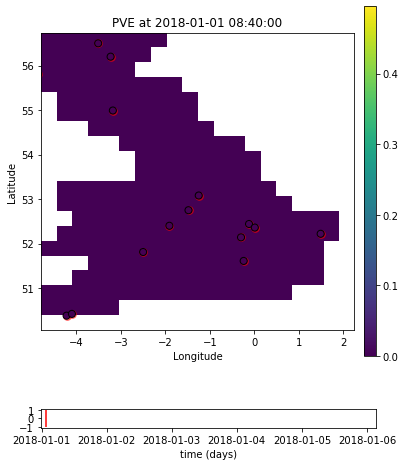

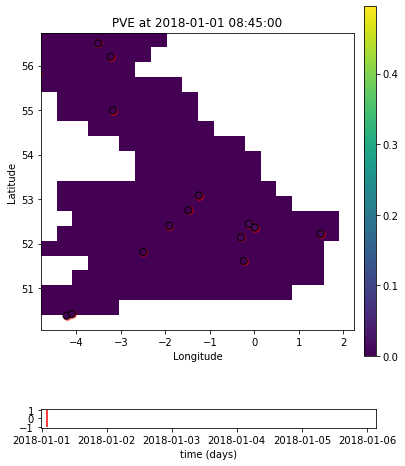

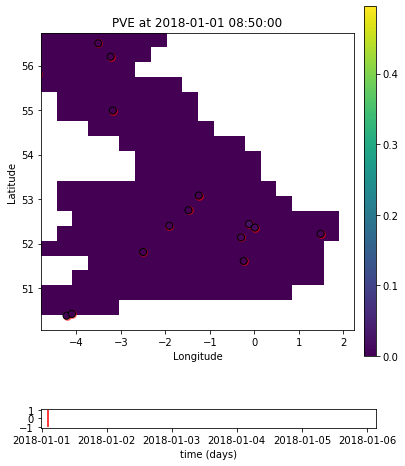

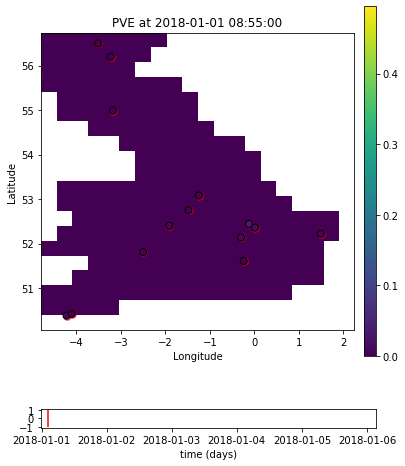

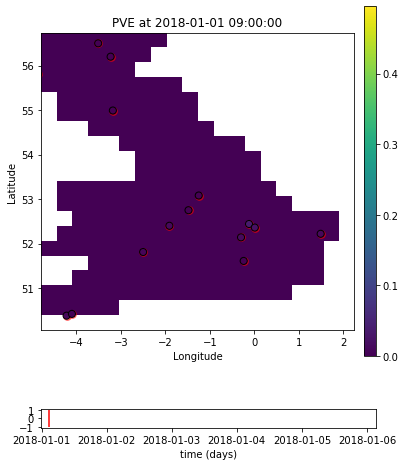

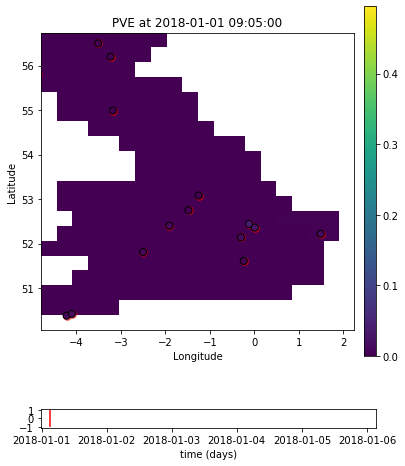

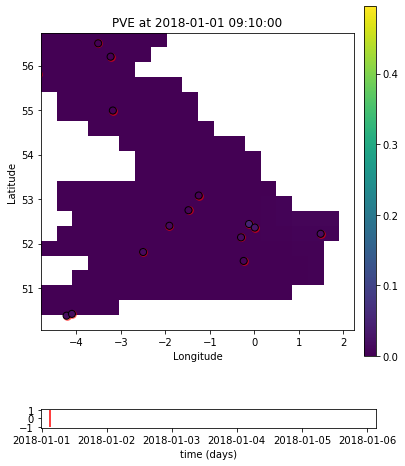

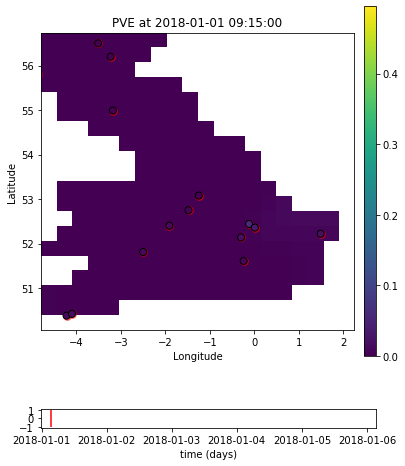

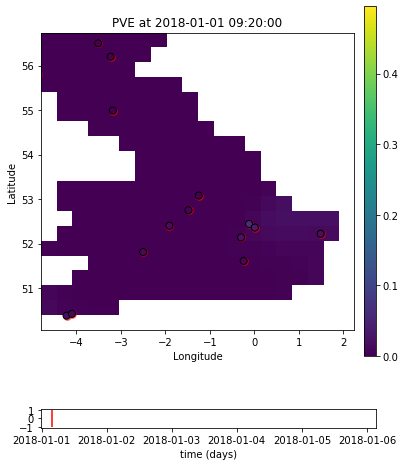

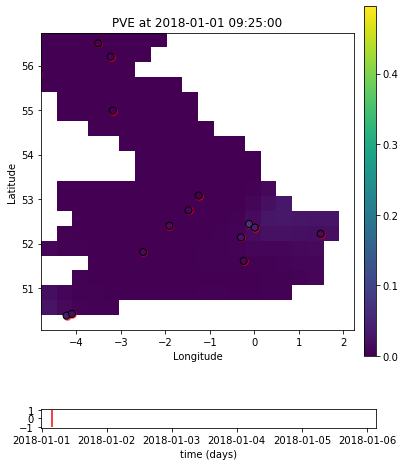

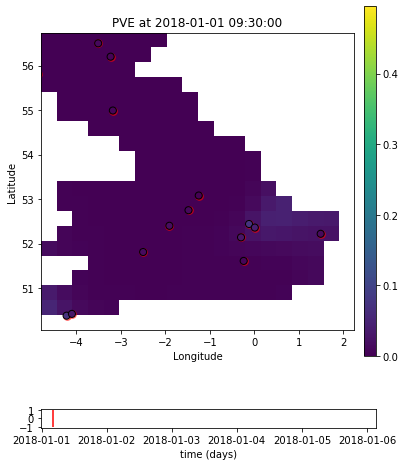

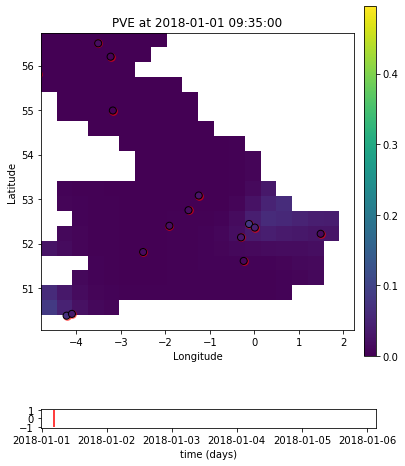

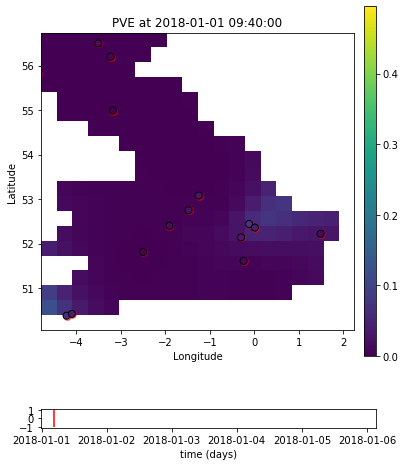

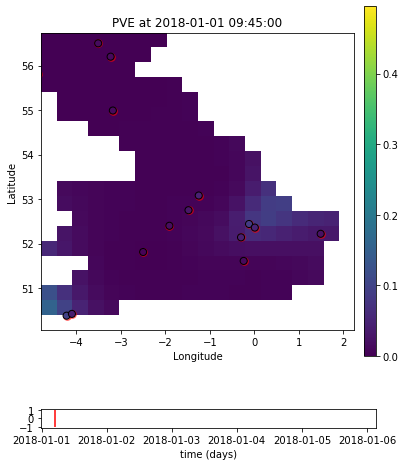

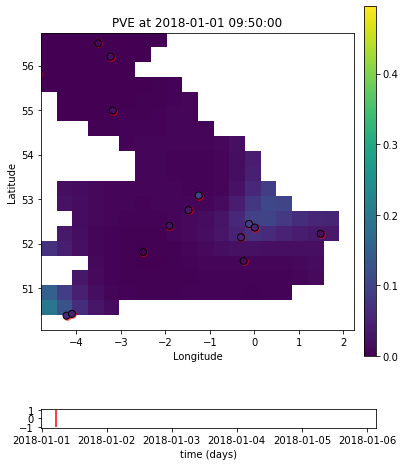

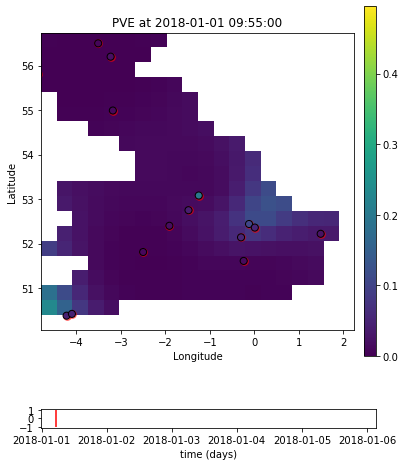

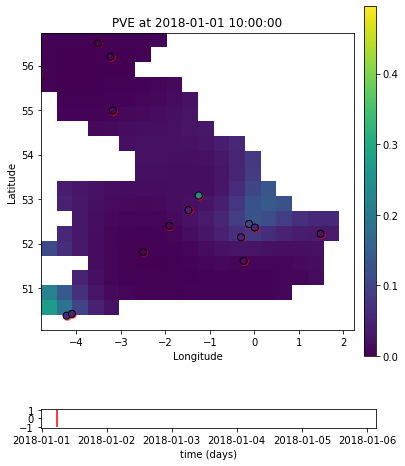

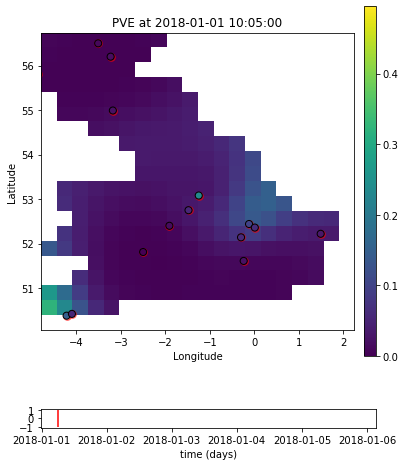

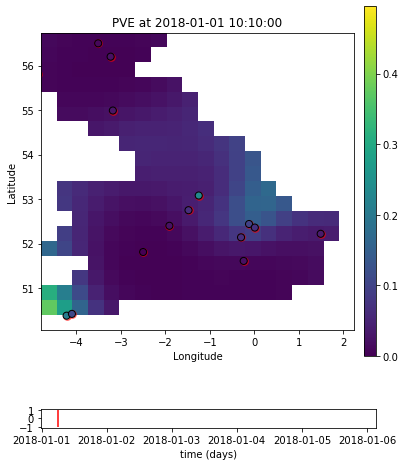

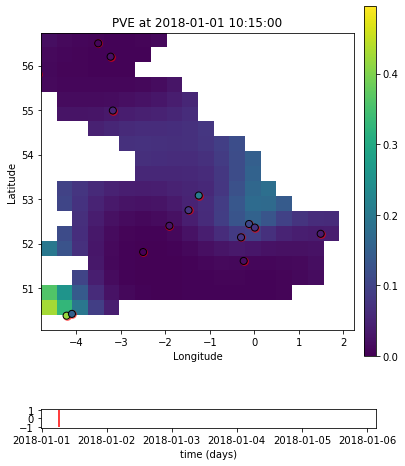

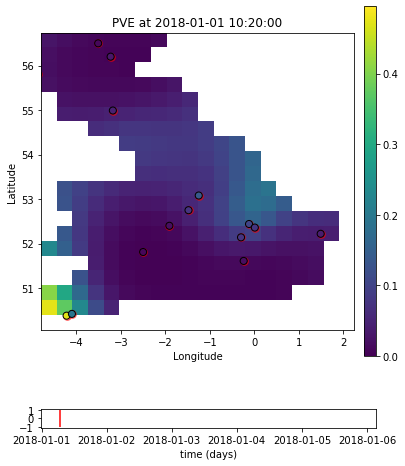

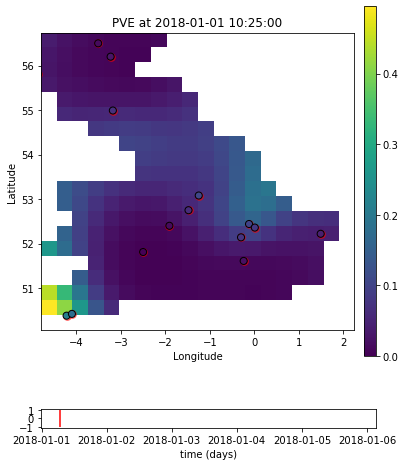

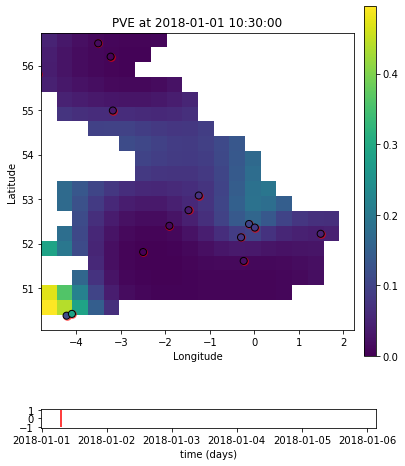

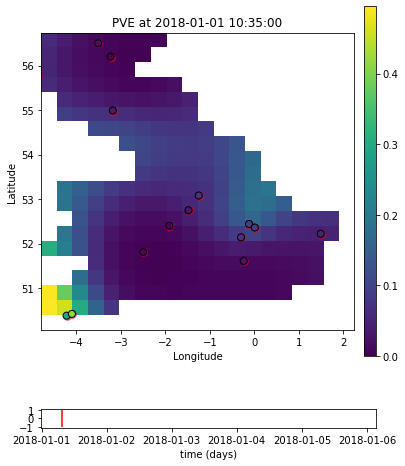

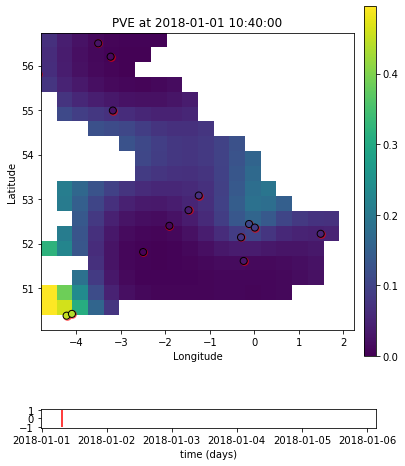

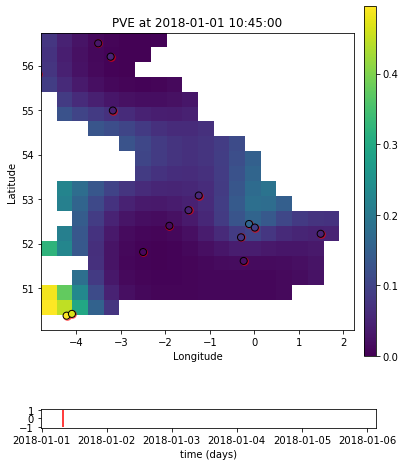

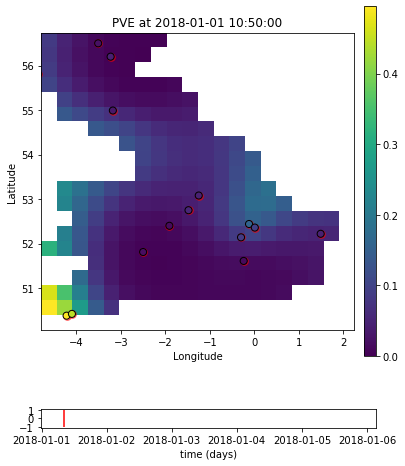

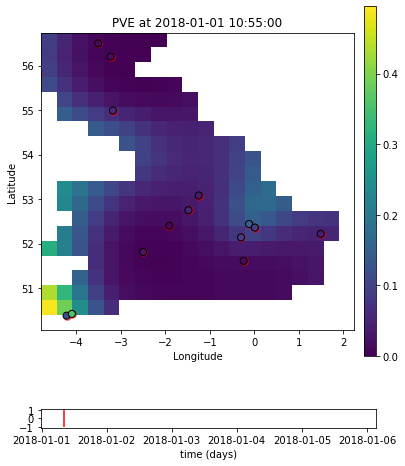

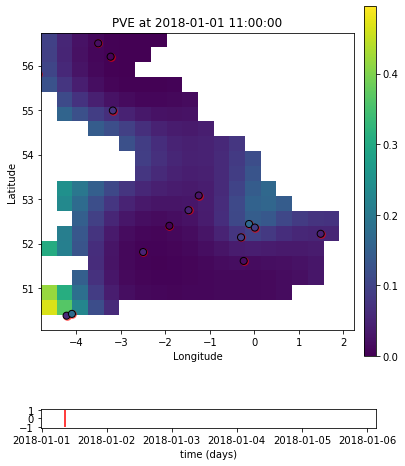

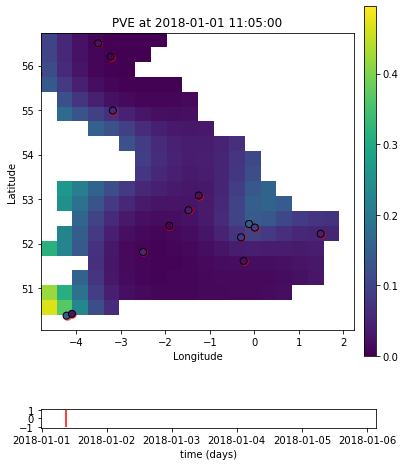

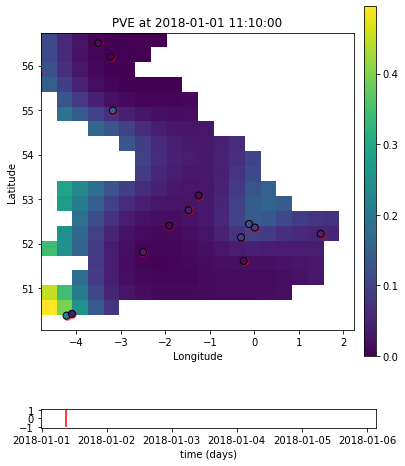

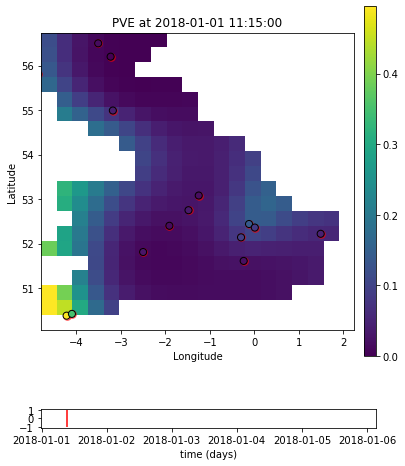

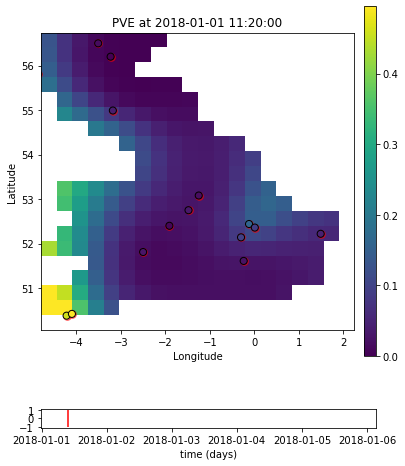

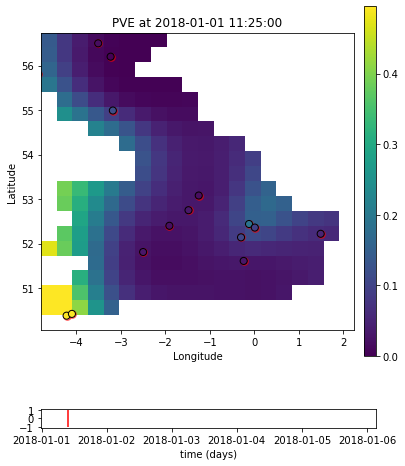

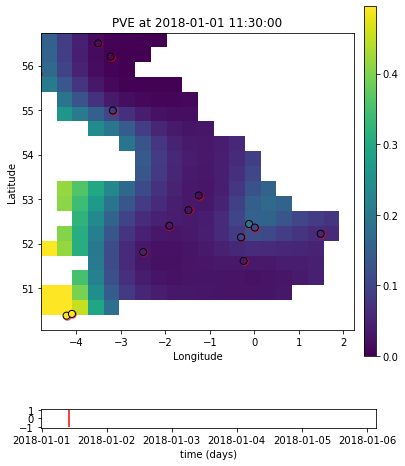

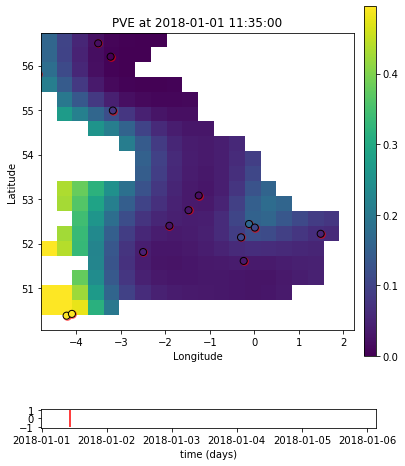

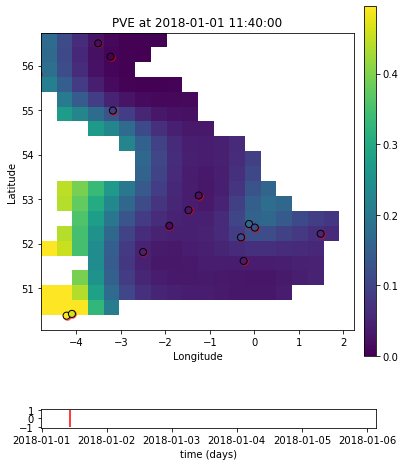

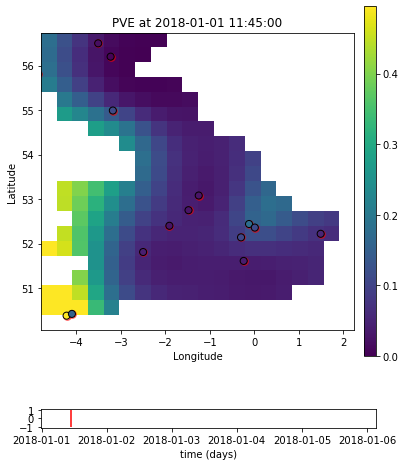

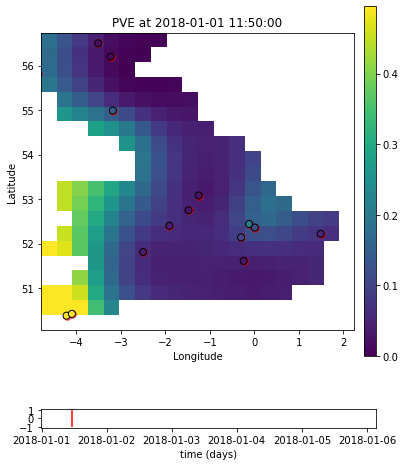

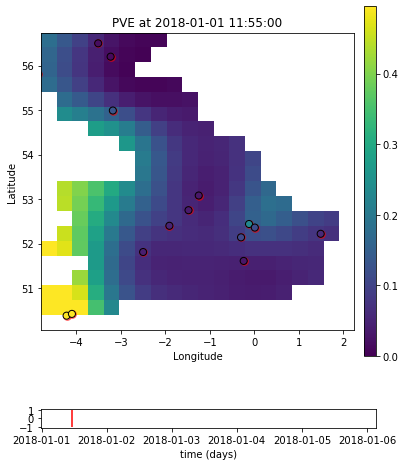

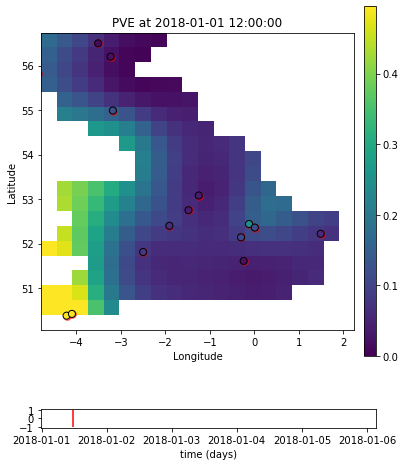

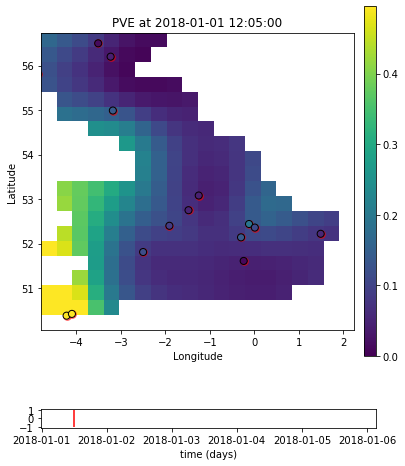

In [12]:
save_result = False
# del model, kern, Rplot  # , var

print('plotting ...')
cmap = cm.viridis
vmin = np.nanpercentile(Y, 1)
vmax = np.nanpercentile(Y, 99)
#get the labels for the dates
dates = pd.to_datetime(data_multiple.datetime).dt.date
days_index = max(97, int(((len(t) / 5) // 97) * 97)) #number of time intervals to match 5 beginnings of days

for time_step in range(t.shape[0])[:50]:
    f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [20, 1]})
    f.set_figheight(8)
    # f.set_figwidth(8)
    im = a0.imshow(mu[time_step], cmap=cmap, vmin=vmin, vmax=vmax,
                   extent=[longitude_grid[0], longitude_grid[-1], latitude_grid[0], latitude_grid[-1]], origin='lower')
    if SPARSE:
        a0.scatter(longitude_z, latitude_z, c='r', s=60, alpha=0.5)  # plot inducing inputs
    a0.scatter(longitude_sys_train, latitude_sys_train, cmap=cmap, vmin=vmin, vmax=vmax,
               c=np.squeeze(Y[time_step]), s=50, edgecolors='black')
    plt.colorbar(im, fraction=0.0348, pad=0.03, aspect=30, ax=a0)
    
    a0.set_xlim(longitude_grid[0], longitude_grid[-1])
    a0.set_ylim(latitude_grid[0], latitude_grid[-1])
    a0.set_title(f'PVE at {data_multiple.datetime.unique()[time_step]}')
    a0.set_ylabel('Latitude')
    a0.set_xlabel('Longitude')
    a1.vlines(t[time_step].item(), -1, 1, 'r')
    a1.set_xlabel('time (days)')
    a1.set_xlim(t[0], t[-1])
    
    a1.set_xticks(np.asarray(t[1:-1:days_index ][:,0].tolist()), 
                  labels = dates[0:-1:days_index].values,
                     fontsize = 10)
    plt.show()
    plt.close(f)

In [13]:
#GET THE SYSTEM SPECIFIC PREDICTIONS (NOT THE TOTAL INTERPOLATION)

posterior_mean_ts, posterior_var_ts = model.predict_y(X=t, R=R_scaled)
# posterior_mean_rescaled = Y_scaler.inverse_transform(posterior_mean_ts)
posterior_pos_twostd_rescaled = posterior_mean_ts + 1.96 * np.sqrt(posterior_var_ts)
posterior_neg_twostd_rescaled = posterior_mean_ts - 1.96 * np.sqrt(posterior_var_ts)

rescaled_Y = (Y * capacities)
rescaled_posterior = posterior_mean_ts * capacities

#adjust this for the correct quantities
rmse = np.sqrt(np.nanmean((np.squeeze(rescaled_Y) - np.squeeze(rescaled_posterior))**2))
print(f'The RMSE is {rmse.round(3)}')

rmse_train = np.sqrt(np.nanmean((np.squeeze(rescaled_Y[~test_mask]) - np.squeeze(rescaled_posterior[~test_mask]))**2))
print(f'The train RMSE is {rmse_train.round(3)}')

rmse_test = np.sqrt(np.nanmean((np.squeeze(rescaled_Y[test_mask]) - np.squeeze(rescaled_posterior[test_mask]))**2))
print(f'The test RMSE is {rmse_test.round(3)}')


The RMSE is 149.898
The train RMSE is 150.467
The test RMSE is 144.682


In [71]:
#GET HERE THE POSTERIOR SAMPLES f(x)_i
post_samp = model.posterior_sample(X=t, R=R_scaled, num_samps=500)

samples_y = np.zeros_like(post_samp)
for sample in range(samples_y.shape[0]):
    #FROM THE POSTERIOR SAMPLES, AND THE ACTUAL ESTIMATED VARIANCE, GET SAMPLES OF Y
    sample_y = model.likelihood.predict(post_samp[sample], posterior_var_ts)[0].reshape(TIMESTEPS_NUM, -1)
    samples_y[sample] = sample_y
    
#GET THE LOWER AND UPPER PERCENTILES WITH 95% CONFIDENCE
lower_perc = np.percentile(samples_y, 2.5, axis=0)
upper_perc = np.percentile(samples_y, 97.5, axis=0)

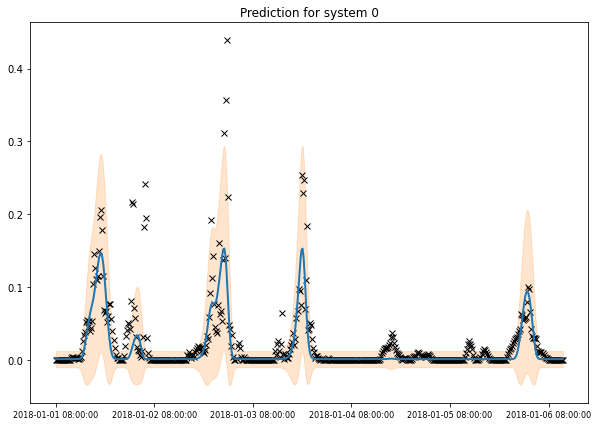

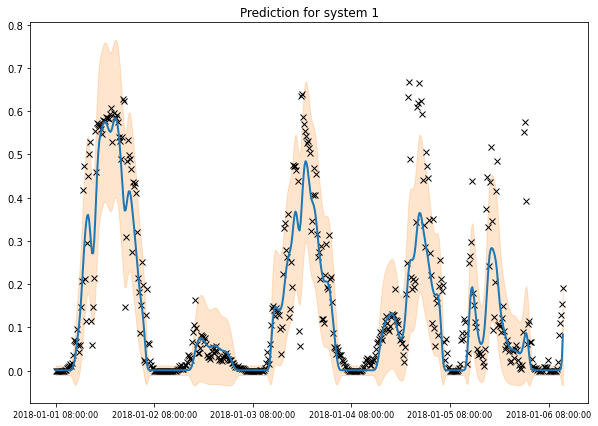

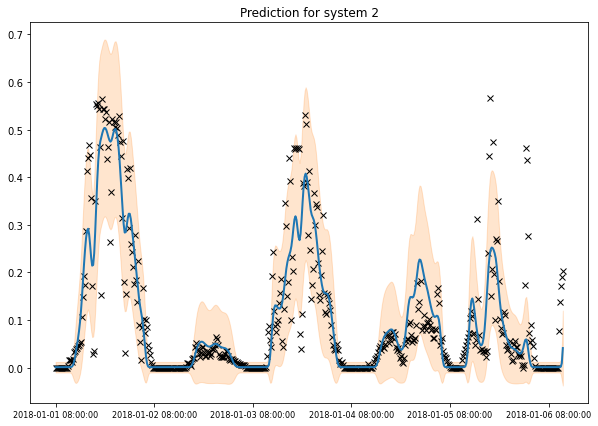

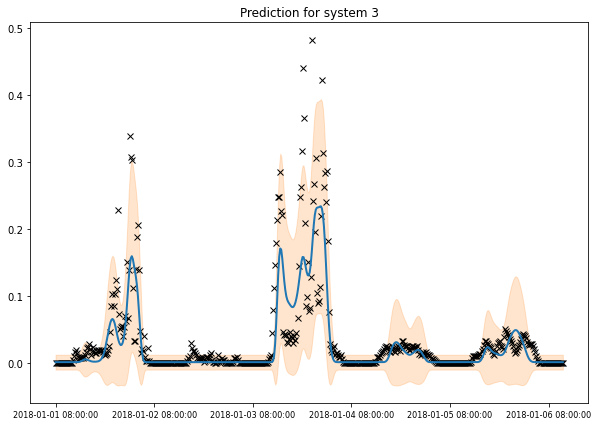

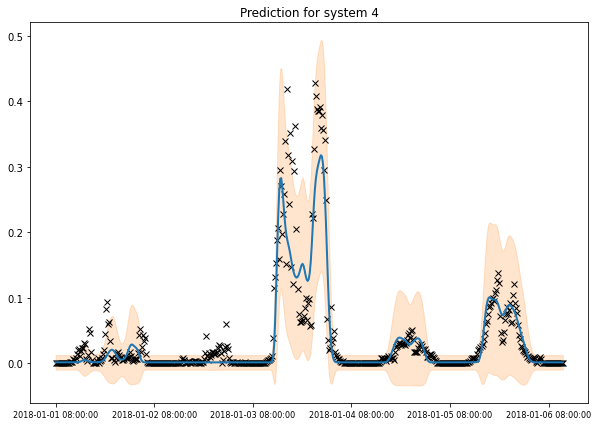

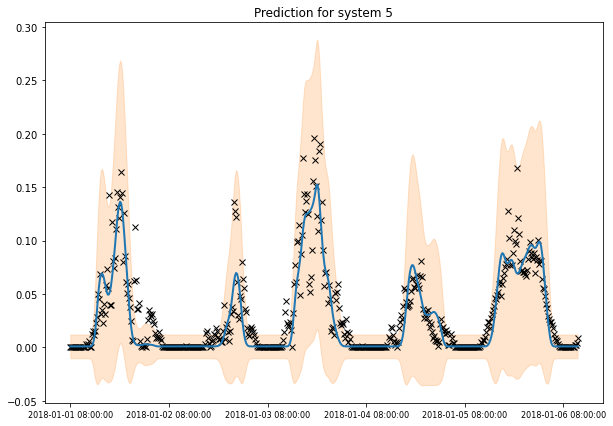

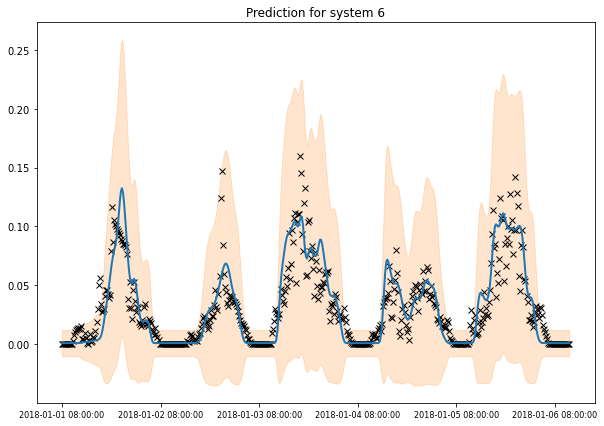

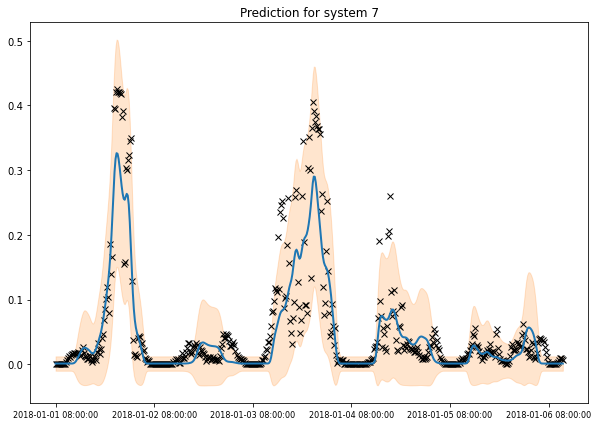

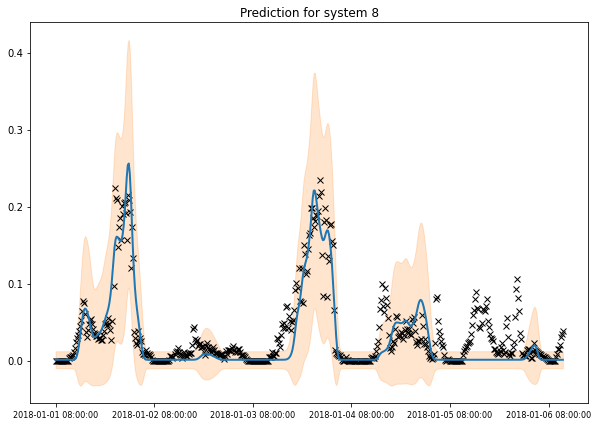

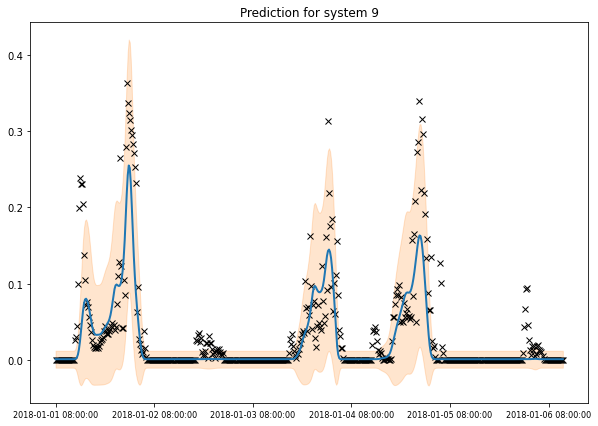

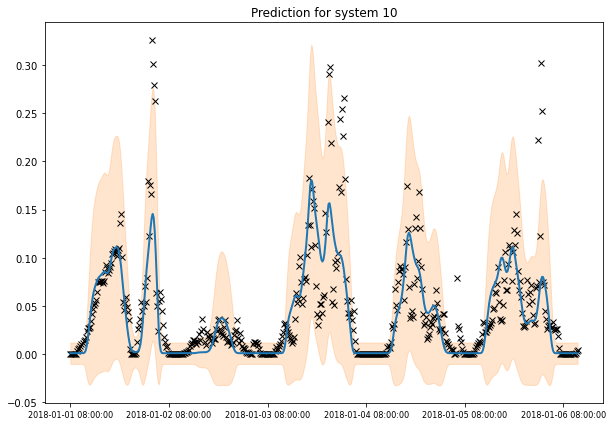

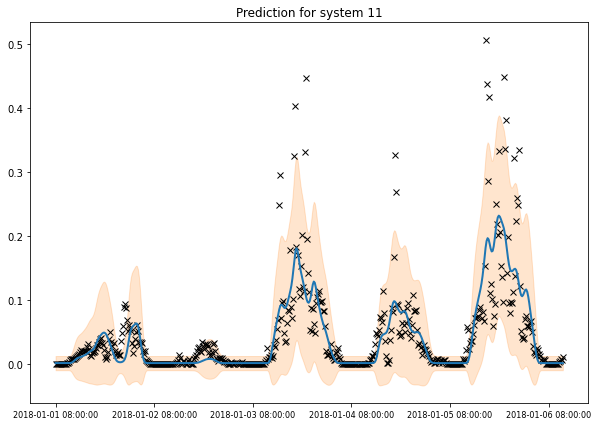

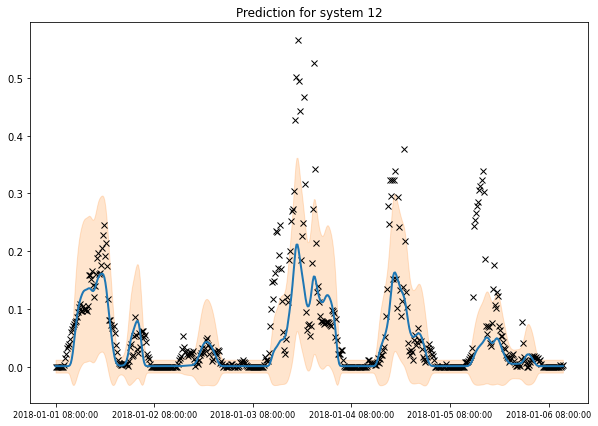

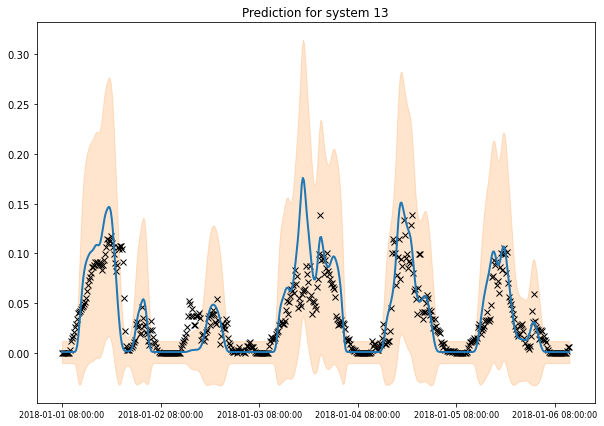

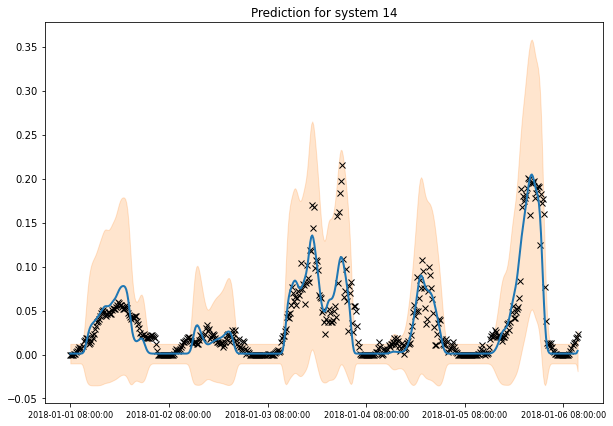

In [104]:
for i in range(SYSTEMS_NUM):
    plt.figure(figsize=(10,7))
    plt.title(f'Prediction for system {i}')
    plt.plot(np.arange(len(Y)), Y[:,i], "xk")
    plt.plot(np.arange(len(Y)), posterior_mean_ts[:,i], c="C0", lw=2, zorder=2)
#     plt.plot(np.arange(len(Y)), post_samp[:,:, i].T)


#     plt.fill_between(
#         np.arange(len(Y)),
#         lower_perc[:,i],
#         upper_perc[:,i],
#         color="C1",
#         alpha=0.2)
    
    plt.fill_between(
        np.arange(len(Y)),
        posterior_neg_twostd_rescaled[:,i],
        posterior_pos_twostd_rescaled[:,i],
        color="C1",
        alpha=0.2)
    
    plt.xticks(ticks = np.arange(len(Y))[0:-1:days_index], labels = data_multiple.datetime[0:-1:days_index].values, size=8)
    

## Predict on Unseen Locations

In [138]:
data_unseen = data.iloc[:, SYSTEMS_NUM:SYSTEMS_NUM+TEST_STATIONS][:TIMESTEPS_NUM].reset_index()
capacities_unseen = uk_pv[uk_pv.ss_id_string.isin(data_unseen.columns)].set_index('ss_id_string')['kwp'].values * 1000
stacked_unseen = mutils.stack_dataframe(data_unseen, lats, longs)

X_unseen = np.array(stacked_unseen[['epoch', 'longitude', 'latitude']])
Y_unseen = np.array(stacked_unseen[['PV']])

# convert to easting and northings
british_national_grid_coords_unseen = convert_bng(X_unseen[:, 1], X_unseen[:, 2])
X_unseen = np.vstack([X_unseen[:, 0],
              np.array(british_national_grid_coords_unseen[0]),
              np.array(british_national_grid_coords_unseen[1])]).T

#Create a space-time grid from X and Y
t, R_unseen, Y_unseen = bayesnewton.utils.create_spatiotemporal_grid(X_unseen, Y_unseen)
R_unseen_scaled = np.tile(R_scaler.transform(R_unseen[0]), (R_unseen.shape[0],1, 1))


In [116]:
N_SAMPLES_UNSEEN = 100000 

posterior_mean_unseen, posterior_var_unseen = model.predict_y(X=t, R=R_unseen_scaled)
f_mean_unseen, f_var_unseen = model.predict(X=t, R=R_unseen_scaled)
sampled_f_unseen = np.random.normal(f_mean_unseen, f_var_unseen, size=(N_SAMPLES_UNSEEN, f_var_unseen.shape[0], f_var_unseen.shape[1]))

samples_y_unseen = np.zeros_like(sampled_f_unseen)
for sample in range(samples_y_unseen.shape[0]):
    #FROM THE POSTERIOR SAMPLES, AND THE ACTUAL ESTIMATED VARIANCE, GET SAMPLES OF Y
    sample_y_unseen = model.likelihood.predict(sampled_f_unseen[sample], posterior_var_unseen)[0].reshape(TIMESTEPS_NUM, -1)
    samples_y_unseen[sample] = sample_y_unseen
    
#GET THE LOWER AND UPPER PERCENTILES WITH 95% CONFIDENCE
lower_perc_unseen = np.percentile(samples_y_unseen, 2.5, axis=0)
upper_perc_unseen = np.percentile(samples_y_unseen, 97.5, axis=0)

# posterior_pos_twostd_rescaled_unseen = posterior_mean_unseen + 1.96 * np.sqrt(posterior_var_unseen)
# posterior_neg_twostd_rescaled_unseen = posterior_mean_unseen - 1.96 * np.sqrt(posterior_var_unseen)



In [73]:
# Y_unseen = Y_unseen[:,:,0]
rescaled_Y_unseen = (Y_unseen * capacities_unseen)
rescaled_posterior_unseen = posterior_mean_unseen * capacities_unseen

#adjust this for the correct quantities
rmse = np.sqrt(np.nanmean((np.squeeze(rescaled_Y_unseen) - np.squeeze(rescaled_posterior_unseen))**2))
print(f'The RMSE is {rmse.round(3)}')

rmse_train = np.sqrt(np.nanmean((np.squeeze(rescaled_Y_unseen[~test_mask]) - np.squeeze(rescaled_posterior_unseen[~test_mask]))**2))
print(f'The train RMSE is {rmse_train.round(3)}')

rmse_test = np.sqrt(np.nanmean((np.squeeze(rescaled_Y_unseen[test_mask]) - np.squeeze(rescaled_posterior_unseen[test_mask]))**2))
print(f'The test RMSE is {rmse_test.round(3)}')


The RMSE is 362.616
The train RMSE is 364.851
The test RMSE is 341.844


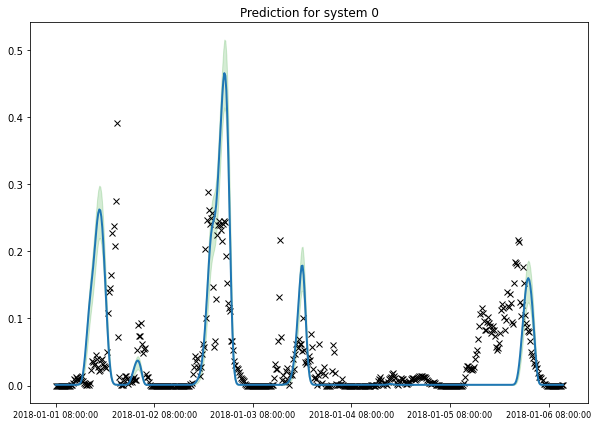

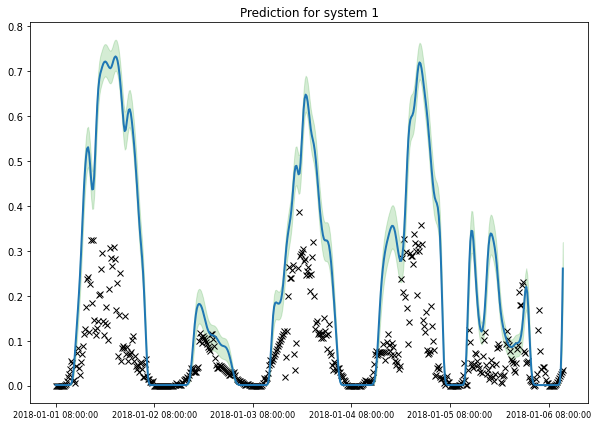

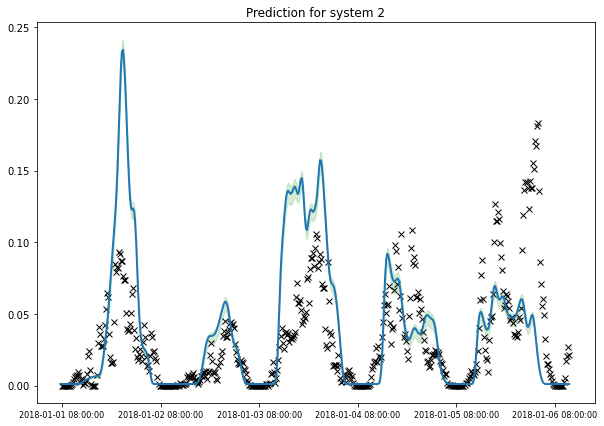

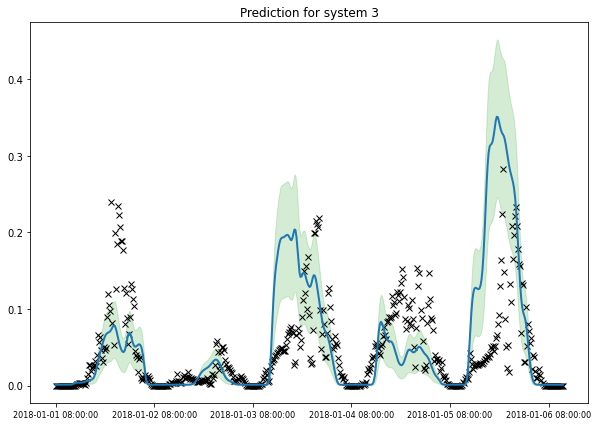

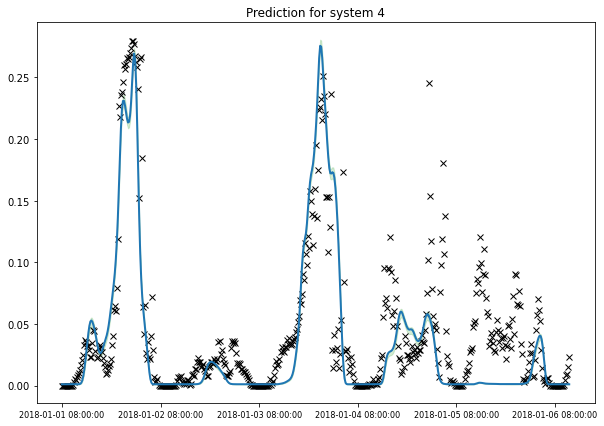

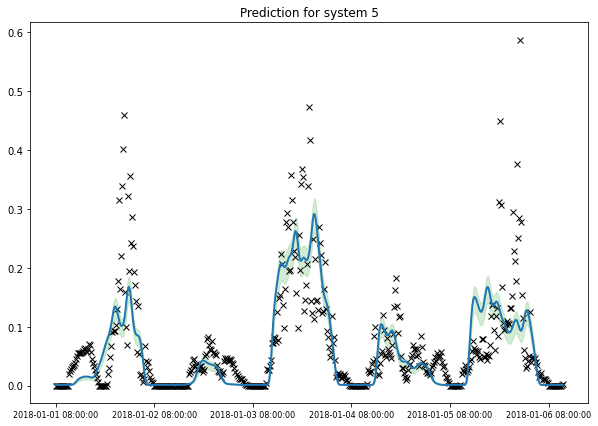

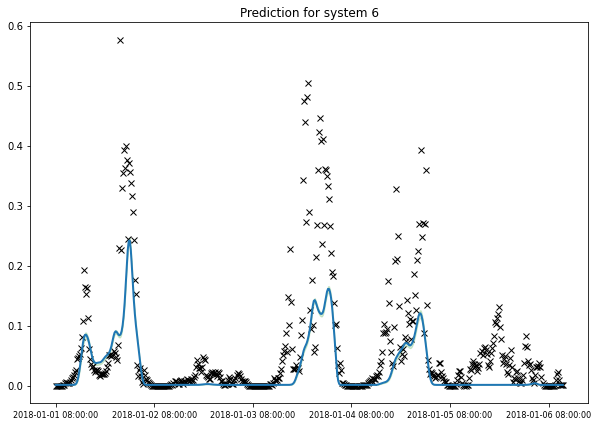

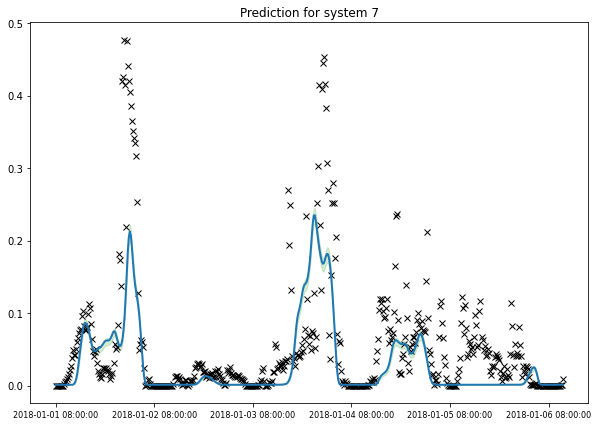

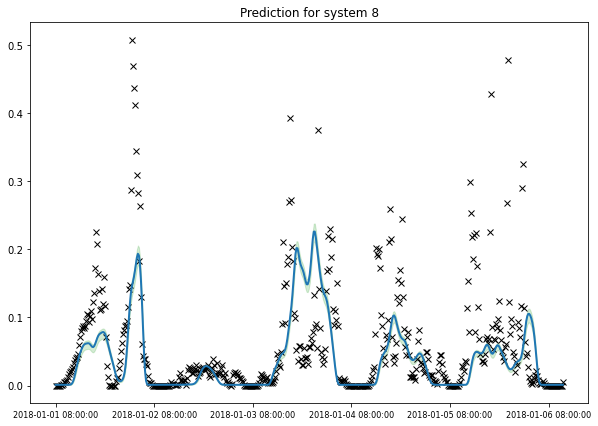

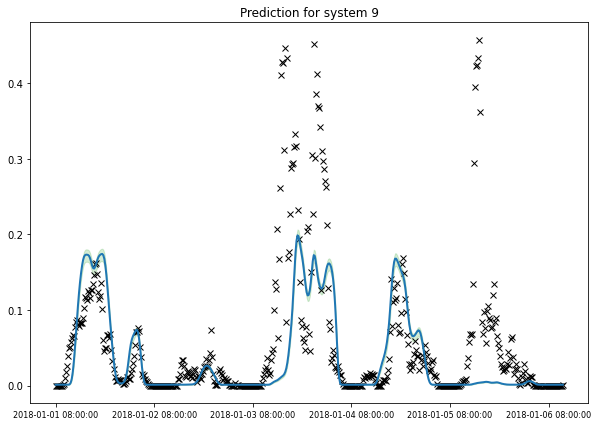

In [117]:
for i in range(TEST_STATIONS):
    plt.figure(figsize=(10,7))
    plt.title(f'Prediction for system {i}')
    plt.plot(np.arange(len(Y)), Y_unseen[:,i], "xk")
    plt.plot(np.arange(len(Y)), posterior_mean_unseen[:,i], c="C0", lw=2, zorder=2)
#     plt.plot(np.arange(len(Y)), sampled_f_unseen[:,:, i].T)
    plt.fill_between(
        np.arange(len(Y)),
        lower_perc_unseen[:,i],
        upper_perc_unseen[:,i],
        color="C2",
        alpha=0.2)
    
#     plt.fill_between(
#         np.arange(len(Y)),
#         posterior_neg_twostd_rescaled_unseen[:,i],
#         posterior_pos_twostd_rescaled_unseen[:,i],
#         color="C1",
#         alpha=0.2)
    
    plt.xticks(ticks = np.arange(len(Y))[0:-1:days_index], labels = data_unseen.datetime[0:-1:days_index].values, size=8)
    

In [ ]:
# model.prior_sample(X = t.flatten(), num_samps=3)[..., 0].shape
# model.predict(X=t, R=R_scaled)[0].shape
# post_samp = model.posterior_sample(X=t, R=R_scaled, num_samps=100)

# model.prior_sample(X = t.flatten(), num_loc = 7, num_samps=3)
# model.posterior_sample(X=t.flatten(), R=Rplot, num_samps=2)
